# Import Necessary Libs

In [1]:
seed = 999

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import xml.etree.ElementTree as ET

from surprise import Dataset, Reader, accuracy, KNNWithMeans, BaselineOnly, SVD
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend
import os, psutil
from sklearnex import patch_sklearn
patch_sklearn()
import surprise

pd.set_option('display.max_columns', None)

In [3]:
np.random.seed(seed)
random.seed(seed)

## Load Dataset

In [4]:
full_df = pd.read_csv('../animelists_cleaned.csv')
full_df

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN


In [5]:
anime_details = pd.read_csv('../AnimeList.csv')

Drop rows where username is missing

In [6]:
full_df = full_df.dropna(subset=['username'])

Drop rows where show score is zero, as this means it is unrated, and therefore useless data

In [7]:
full_df = full_df[full_df['my_score'] > 0]

In [8]:
full_df.describe()

,anime_id,my_watched_episodes,my_score,my_status,my_rewatching,my_rewatching_ep
count,1.917195e+07,1.917195e+07,1.917195e+07,1.917195e+07,1.411264e+07,1.917195e+07
mean,1.127331e+04,1.809466e+01,7.591404e+00,2.081085e+00,1.202398e-03,2.989212e-01
std,1.101460e+04,4.303521e+01,1.706195e+00,5.134124e-01,3.465475e-02,1.289120e+03
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.562000e+03,2.000000e+00,7.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,7.724000e+03,1.200000e+01,8.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
75%,1.867700e+04,2.200000e+01,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
max,3.786000e+04,9.999000e+03,1.000000e+01,3.300000e+01,1.000000e+00,5.644513e+06


## Exploratory data analysis

In [9]:
sns.set(rc = {'figure.figsize':(10,10)})

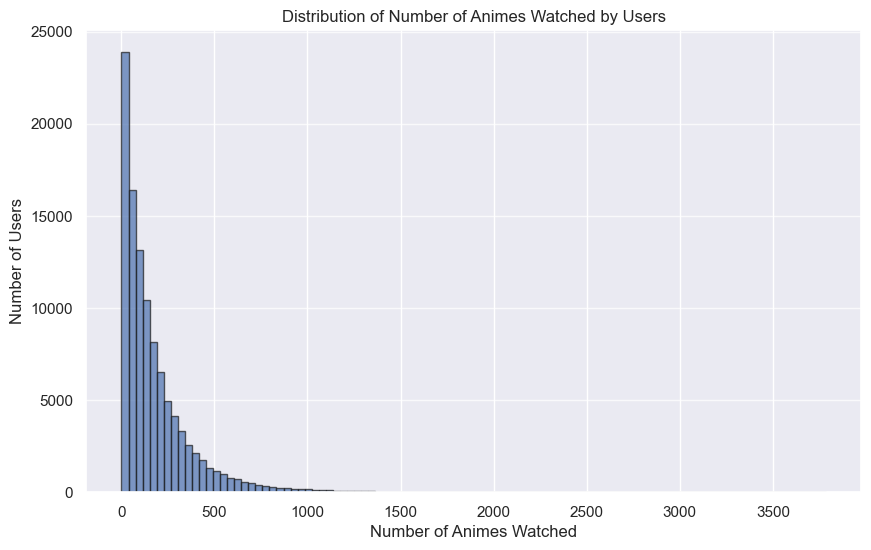

In [10]:
# Step 1: Count the number of animes each user has watched
user_anime_counts = full_df['username'].value_counts()

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_anime_counts, bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Animes Watched by Users')
plt.xlabel('Number of Animes Watched')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
full_df['username'].value_counts()

_thiagobrisolla    3785
misterferrari      3442
Shouichirou        3439
SakataYusuke       3383
Kannei             3285
                   ... 
psithurism            1
shaz40                1
karkat                1
Miikan-chan           1
hinogurl_mikha        1
Name: username, Length: 106401, dtype: int64

C:\Users\Mashal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


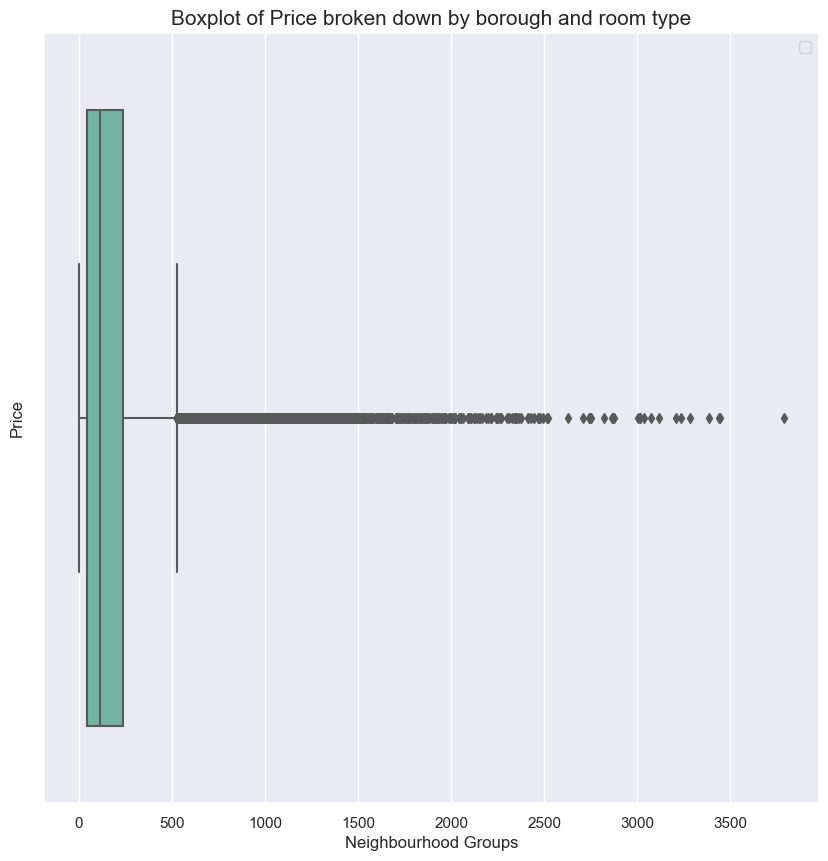

In [12]:
sns.boxplot(user_anime_counts, palette="Set2")
plt.title('Boxplot of Price broken down by borough and room type', fontsize = 15)
plt.xlabel('Neighbourhood Groups')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1, 1))
plt.show();

In [13]:
full_df[full_df['username'] != "karthiga"]

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
53,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,2009-09-30 07:39:05,NaN
55,Damonashu,249,167,0000-00-00,0000-00-00,4,2,0.0,0,1970-01-01 00:00:00,NaN
56,Damonashu,269,0,0000-00-00,0000-00-00,2,4,NaN,0,1970-01-01 00:00:00,NaN
57,Damonashu,853,26,0000-00-00,2009-07-31,6,2,0.0,0,2009-07-31 21:07:47,NaN
58,Damonashu,857,25,0000-00-00,2008-08-11,4,2,0.0,0,2008-08-11 17:45:54,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN


Keep removing users at random until a user threshold is reached

In [14]:
# usernames = full_df['username'].unique()
# np.random.shuffle(usernames)
# limit = 10000
# username_ind = 0
# while len(full_df['username'].unique()) > limit:
#     full_df = full_df[full_df['username'] != usernames[username_ind]]
#     username_ind += 1

In [15]:
# Get unique users
unique_users = full_df['username'].unique()

# Randomly select users to keep (10,000)
num_users_to_keep = min(len(unique_users), 1000)  # Ensure we keep at most 10,000 users
selected_users = np.random.choice(unique_users, size=num_users_to_keep, replace=False)

# Filter the DataFrame to retain only rows with the selected users
anime_df = full_df[full_df['username'].isin(selected_users)]

print(f"Original number of unique users: {len(unique_users)}")
print(f"Number of unique users after filtering: {anime_df['username'].nunique()}")
print(anime_df.head())

Original number of unique users: 106401
Number of unique users after filtering: 1000
        username  anime_id  my_watched_episodes my_start_date my_finish_date  \
9564  magedgamed        21                  688    0000-00-00     0000-00-00   
9565  magedgamed        59                   26    0000-00-00     2016-08-12   
9566  magedgamed       120                   26    2015-12-12     2015-12-13   
9567  magedgamed       232                   70    0000-00-00     2016-03-21   
9569  magedgamed       249                  167    0000-00-00     2017-02-05   

      my_score  my_status  my_rewatching  my_rewatching_ep  \
9564         9          3            NaN                 0   
9565         6          2            0.0                 0   
9566         7          2            0.0                 0   
9567         7          2            0.0                 0   
9569         6          2            0.0                 0   

          my_last_updated       my_tags  
9564  2015-06-01 18

In [16]:
# Here we confirm that the anime ids of the full dataset is a proper subset of the ids in the information dataset
unique_ids_full = full_df['anime_id'].unique()
unique_ids_details = anime_details['anime_id'].unique()
np.all(np.isin(unique_ids_full, unique_ids_details)) and len(unique_ids_full) < len(unique_ids_details)

True

To reduce the dimensionality of the user-item rating matrix in the numpy arrays later, I reduce the index range.

In [17]:
unique_ids = anime_details['anime_id'].unique()
# Gets list of unique IDs and sorts them
indToId = np.sort(unique_ids)
# Contains translations from anime IDs to numpy array indices
idToInd = {}
for i in range(len(indToId)):
    idToInd[indToId[i]] = i

Adds user ID column

In [18]:
anime_df['user_id'] = pd.factorize(anime_df['username'])[0]

C:\Users\Mashal\AppData\Local\Temp\ipykernel_21156\278079498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['user_id'] = pd.factorize(anime_df['username'])[0]


# Split Dataset into Training Dataset and Testing Dataset

In [19]:
train_df, test_df = train_test_split(anime_df, test_size=0.2)
train_df, test_df

(                 username  anime_id  my_watched_episodes my_start_date  \
 10352542         THK-wolf      1815                    1    0000-00-00   
 6170925             Ryu82     28223                   12    0000-00-00   
 12189590         Drakox_x     14741                   12    0000-00-00   
 16456923     MateuszB1987     24873                   12    2015-01-30   
 30774979           Mydlak     10067                    1    2013-05-02   
 ...                   ...       ...                  ...           ...   
 23305424        pacman912        30                   26    2014-06-25   
 9420800            wotorr     19021                    1    0000-00-00   
 19507415       malonej206      9253                    8    0000-00-00   
 13253408  AmethystMoon420     11741                   12    2014-09-27   
 16261319            raiho     35720                    6    0000-00-00   
 
          my_finish_date  my_score  my_status  my_rewatching  my_rewatching_ep  \
 10352542     00

In [20]:
for row in train_df.itertuples():
    print(row)
    break

Pandas(Index=10352542, username='THK-wolf', anime_id=1815, my_watched_episodes=1, my_start_date='0000-00-00', my_finish_date='0000-00-00', my_score=6, my_status=2, my_rewatching=0.0, my_rewatching_ep=0, my_last_updated='2009-03-10 14:33:25', my_tags=nan, user_id=2297)


In [21]:
print(train_df.itertuples(index=False).__next__()._fields)


('username', 'anime_id', 'my_watched_episodes', 'my_start_date', 'my_finish_date', 'my_score', 'my_status', 'my_rewatching', 'my_rewatching_ep', 'my_last_updated', 'my_tags', 'user_id')


In [22]:
anime_df[(anime_df['user_id']==40352)] #  & (anime_df['anime_id']==indToId[3])

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id


In [23]:
n_users = anime_df['user_id'].nunique()
n_items = anime_details['anime_id'].nunique()

In [24]:
train_df.sort_values(by='user_id')

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id
7413,Akihara,5118,25,0000-00-00,0000-00-00,4,2,0.0,0,2009-06-20 08:33:34,NaN,0
7619,Akihara,6467,1,2013-10-29,2013-10-29,8,2,NaN,0,2013-10-29 18:14:24,NaN,0
7182,Akihara,486,13,2017-12-28,2017-12-29,8,2,0.0,0,2017-12-29 10:07:43,NaN,0
7361,Akihara,13271,1,2013-08-01,2013-08-01,10,2,NaN,0,2013-08-01 13:34:13,NaN,0
7379,Akihara,154,64,0000-00-00,0000-00-00,10,2,NaN,0,2008-08-19 09:02:31,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31283935,spo7goro,5028,25,1996-09-28,0000-00-00,10,2,NaN,0,2009-07-15 11:08:55,basta,9998
31283934,spo7goro,3226,26,0000-00-00,0000-00-00,10,1,NaN,0,2009-07-15 11:12:52,ha,9998
31283944,1LUCY3553,10370,52,0000-00-00,0000-00-00,10,2,0.0,0,2012-07-16 11:56:13,NaN,9999
31283942,1LUCY3553,7645,12,0000-00-00,0000-00-00,8,1,NaN,0,2012-05-18 13:57:16,NaN,9999


In [25]:
# Training dataset
train_ds = np.zeros((n_users, n_items))
for row in train_df.itertuples():
    train_ds[row.user_id, idToInd[row.anime_id]] = row.my_score
train_ds = pd.DataFrame(train_ds)

# Testing dataset
test_ds = np.zeros((n_users, n_items))
for row in test_df.itertuples():
    test_ds[row.user_id, idToInd[row.anime_id]] = row.my_score
test_ds = pd.DataFrame(test_ds)

# Fitting the Algorithm

## User-based

### Compute Pearson Correlation Coefficient for Each Pair of Users in Training Dataset

\begin{equation} 
sim(A,B) = \frac{\sum_{i \in I(A) \cap I(B)}(r_{a,i} - \bar{r_a})(r_{b,i} - \bar{r_b})}
{\sqrt{\sum_{i \in I(A) \cap I(B)}(r_{a,i} - \bar{r_a})^2} \sqrt{\sum_{i \in I(A) \cap I(B)}(r_{b,i} - \bar{r_b})^2}}
\end{equation}

\begin{equation}
sim(A,B) \rightarrow \frac{min(|I(A)\cap I(B)|, \gamma)} {\gamma} sim(A,B)
\end{equation}

In [26]:
GAMMA = 30
EPSILON = 1e-9

np_user_pearson_corr = np.zeros((n_users, n_users))

for i, user_i_vec in enumerate(train_ds.values):
    for j, user_j_vec in enumerate(train_ds.values):

        # ratings corated by the current pair od users
        mask_i = user_i_vec > 0
        mask_j = user_j_vec > 0

        # corrated item index, skip if there are no corrated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # average value of user_i_vec and user_j_vec
        mean_user_i = np.sum(user_i_vec) / (np.sum(np.clip(user_i_vec, 0, 1)) + EPSILON)
        mean_user_j = np.sum(user_j_vec) / (np.sum(np.clip(user_j_vec, 0, 1)) + EPSILON)

        # compute pearson corr
        user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
        user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

        r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
        r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

        r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
        r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

        sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

        # significance weighting
        weighted_sim = (min(len(corrated_index), GAMMA) / GAMMA) * sim

        np_user_pearson_corr[i][j] = weighted_sim

np_user_pearson_corr

array([[ 1.00000000e+00,  5.03061363e-01,  2.24522400e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.03061363e-01,  1.00000000e+00, -1.32513908e-03, ...,
         3.33333333e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.24522400e-01, -1.32513908e-03,  1.00000000e+00, ...,
        -3.43213766e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  3.33333333e-02, -3.43213766e-02, ...,
         7.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.33333355e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.66666665e-02]])

### Predict Ratings

\begin{equation}
P(r_{x,i}) = \bar{x} + \frac{\sum_{u \in S(x)} sim(x,u)(r_{u,i}-\bar{u})}{\sum_{u \in S(x)} sim(x,u)}
\end{equation}

In [27]:
np_predictions = np.zeros((n_users, n_items))

K = 50
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = np_user_pearson_corr[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 10)
    

### Evaluation

#### Root Mean Squared Error (RMSE)

In [28]:
#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Testing set (User-based): " + str(RMSE));

RMSE on Testing set (User-based): 1.3450357989377657


#### Mean Absolute Error (MAE)

In [29]:
#==================MAE on Testing set===================#
labels = test_ds.values

# absolute error on all ratings
absolute_error = np.abs(np_predictions - labels)

# weight
weight = np.clip(labels, 0, 1)

# absoulte error on rated ratings
abs_error = absolute_error * weight

# MAE
MAE = np.sum(abs_error) / np.sum(weight)

print("MAE on Testing set (User-based): " + str(MAE));

MAE on Testing set (User-based): 1.001280691425842


In [30]:
np_predictions

array([[0.        , 8.40002978, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 9.04582328, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 8.39867906, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

We now begin to predict the rating of all movies for 1 user

In [26]:
test_np = test_ds.to_numpy()
train_np = train_ds.to_numpy()
test_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 8., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
train_np

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 8.,  0.,  7., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Combine testing and training datasets

In [28]:
anime_ds = np.maximum(train_np, test_np)
anime_ds

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 8.,  8.,  7., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [29]:
user0_rated = anime_ds[0] > 0
user0_rated[:100]

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [30]:
user1_rated = anime_ds[1] > 0
user1_rated[:100]

array([ True,  True,  True, False, False,  True,  True, False, False,
        True, False,  True, False, False,  True,  True,  True, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True])

In [31]:
anime_ds[0][:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
GAMMA = 30
EPSILON = 1e-9

user0_corr = np.zeros(len(anime_ds) - 1)
user0_mean = np.sum(anime_ds[0]) / (np.sum(np.clip(anime_ds[0], 0, 1)) + EPSILON)

for i in range(1, len(anime_ds)):
    row_rated = anime_ds[i] > 0
    corated_index = np.intersect1d(np.where(user0_rated), np.where(row_rated))
    if len(corated_index) == 0:
        continue
    
    sim_user_mean = np.sum(anime_ds[i]) / (np.sum(np.clip(anime_ds[i], 0, 1)) + EPSILON)
    centered_user0 = anime_ds[0][corated_index] - user0_mean
    centered_sim_user = anime_ds[i][corated_index] - sim_user_mean
    
    coratings_sum = np.sum(centered_user0 * centered_sim_user)
    
    # Compute square root of squared sums
    sum_root_user0 = np.sqrt(np.sum(np.square(centered_user0)))
    sum_root_sim_user = np.sqrt(np.sum(np.square(centered_sim_user)))
    
    similarity = coratings_sum / (sum_root_user0 * sum_root_sim_user + EPSILON)
    
    weighted_similarity = similarity * (min(len(corated_index), GAMMA) / GAMMA)
    
    user0_corr[i-1] = weighted_similarity
user0_corr

array([0.29426074, 0.51185285, 0.52601954, ..., 0.        , 0.        ,
       0.        ])

## NumPy working out

In [33]:
np.arange(20).reshape(4,5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [34]:
twenty = np.arange(20).reshape(4,5).T
twenty

array([[ 0,  5, 10, 15],
       [ 1,  6, 11, 16],
       [ 2,  7, 12, 17],
       [ 3,  8, 13, 18],
       [ 4,  9, 14, 19]])

In [35]:
np.hstack([twenty,[[el] for el in np.arange(5)]])

array([[ 0,  5, 10, 15,  0],
       [ 1,  6, 11, 16,  1],
       [ 2,  7, 12, 17,  2],
       [ 3,  8, 13, 18,  3],
       [ 4,  9, 14, 19,  4]])

In [36]:
diagram = np.arange(25).reshape(5,5).T
diagram[:,-1] = np.arange(5)
diagram[-1,:] = np.arange(5)
diagram

array([[ 0,  5, 10, 15,  0],
       [ 1,  6, 11, 16,  1],
       [ 2,  7, 12, 17,  2],
       [ 3,  8, 13, 18,  3],
       [ 0,  1,  2,  3,  4]])

In [37]:
twenty > 10

array([[False, False, False,  True],
       [False, False,  True,  True],
       [False, False,  True,  True],
       [False, False,  True,  True],
       [False, False,  True,  True]])

In [38]:
anime_ds[:19,2]

array([ 0.,  7.,  0.,  0.,  0.,  8., 10.,  0.,  0.,  9.,  8.,  0.,  7.,
        7.,  0.,  8.,  0.,  0.,  0.])

In [39]:
len(anime_ds[:,2] > 0)

10000

In [40]:
len(np.zeros(len(anime_ds.T)))

14478

In [41]:
K = 50
ratings = np.zeros(len(anime_ds.T))
user0_mean = np.sum(anime_ds[0]) / (np.sum(np.clip(anime_ds[0], 0, 1)) + EPSILON)

for i in range(len(anime_ds.T)):
    # Selects all users that have rated item i
    rated_users = anime_ds[1:,i] > 0
    
    # Selects the K nearest neighbours, whom have rated item i
    if len(rated_users) >= K:
        sim_user_ids = np.argsort(user0_corr[rated_users])[-K:]
    else:
        sim_user_ids = np.argsort(user0_corr[rated_users])
        
    # the coefficient values of similar users
    sim_val = user0_corr[rated_users][sim_user_ids]
    
    # the average value of the current user's ratings
    
    # This indexes from the second anime_ds row onwards, all the rated users, then the indices of the sim_user_ids
    sim_users = anime_ds[1:][rated_users][sim_user_ids]
    sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)
    
    # sim(u, v) * (r_vj - mean_v)
    sim_r_sum_mean = sim_val * (sim_users[:, i] - sim_user_mean)

    ratings[i] = user0_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val) + EPSILON)
ratings

array([8.84660887, 8.66218354, 8.47756323, ..., 7.45605307, 7.45605307,
       7.45605307])

In [42]:
np.argsort(ratings)[::-1]

array([ 1915,  4359,  7414, ...,   945, 13091, 11590], dtype=int64)

In [43]:
top_animes = np.zeros(10)
for i in range(10):
    top_animes[i] = indToId[np.argsort(ratings)[::-1][i]]
top_df = pd.DataFrame(top_animes, columns=['anime_id'])

In [44]:

pd.merge(anime_df[anime_df['user_id']==0], anime_details, how="inner", on='anime_id').sort_values(by='my_score', ascending=False).head(2)

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
369,Akihara,10189,1,2013-04-08,2013-04-08,10,2,NaN,0,2013-04-08 15:06:09,NaN,0,Hunter x Hunter Pilot,NaN,ハンターxハンター,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Manga,1,Finished Airing,False,1998,"{'from': None, 'to': None}",25 min.,PG-13 - Teens 13 or older,7.33,6156,2307.0,3245,13470,37,NaN,NaN,NaN,"{'Adaptation': [{'mal_id': 26, 'type': 'manga'...",NaN,NaN,Studio Pierrot,"Action, Adventure, Shounen, Super Power",[],[]
202,Akihara,4155,1,0000-00-00,0000-00-00,10,2,0.0,0,2011-10-26 16:50:59,NaN,0,One Piece Film: Strong World,One Piece Film Strong World,ワンピース フィルム ストロングワールド,One Piece Movie 10,https://myanimelist.cdn-dena.com/images/anime/...,Movie,Manga,1,Finished Airing,False,"Dec 12, 2009","{'from': '2009-12-12', 'to': '2009-12-12'}",1 hr. 55 min.,PG-13 - Teens 13 or older,8.33,73981,210.0,755,114843,362,NaN,NaN,NaN,"{'Parent story': [{'mal_id': 21, 'type': 'anim...",NaN,Funimation,Toei Animation,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",[],"['""fanfare"" by Mr.Children']"


In [45]:
result = pd.merge(top_df, anime_details, on='anime_id', how='left')
result

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,2095.0,Salamander,NaN,沙羅曼蛇,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Game,3,Finished Airing,False,"Feb 25, 1987 to Feb 25, 1989","{'from': '1987-02-25', 'to': '1989-02-25'}",53 min. per ep.,PG-13 - Teens 13 or older,6.08,277,7124.0,8693,803,0,NaN,NaN,NaN,[],Pony Canyon,NaN,Studio Pierrot,"Adventure, Sci-Fi",[],"['""I Remember You"" by Yasuhiko Shigemura']"
1,5895.0,Tistou Midori no Oyayubi,Tistou the Green Thumb,チスト みどりのおやゆび,"Tistou of the Green Fingers, Tistou of the Gre...",https://myanimelist.cdn-dena.com/images/anime/...,Movie,Original,1,Finished Airing,False,"Mar 24, 1990","{'from': '1990-03-24', 'to': '1990-03-24'}",1 hr. 14 min.,G - All Ages,6.90,75,3933.0,9728,448,0,NaN,NaN,NaN,[],NaN,NaN,Production I.G,"Historical, Magic",[],[]
2,16255.0,Meisou-Ou Border,NaN,迷走王 ボーダー,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Manga,1,Finished Airing,False,"Sep 1, 1991","{'from': '1991-09-01', 'to': '1991-09-01'}",43 min.,PG-13 - Teens 13 or older,5.66,106,8087.0,10314,327,0,NaN,NaN,NaN,[],NaN,NaN,Artland,"Adventure, Seinen",[],[]
3,13449.0,Shippuu! Iron Leaguer: Silver no Hata no Moto ni,NaN,疾風! アイアンリーガー 銀光の旗の下に,"Shippu Iron Leaguer OVA, Hurricane! Iron Leagu...",https://myanimelist.cdn-dena.com/images/anime/...,OVA,Original,5,Finished Airing,False,"Nov 21, 1994 to Apr 25, 1995","{'from': '1994-11-21', 'to': '1995-04-25'}",30 min. per ep.,PG-13 - Teens 13 or older,6.86,49,12096.0,11170,207,1,NaN,NaN,NaN,"{'Prequel': [{'mal_id': 2758, 'type': 'anime',...",NaN,NaN,Sunrise,"Sports, Mecha",[],[]
4,7155.0,Beat Shot!!,Watch Me Sink My Putz,ビートショット!!,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Manga,1,Finished Airing,False,"May 25, 1989","{'from': '1989-05-25', 'to': '1989-05-25'}",27 min.,Rx - Hentai,5.55,95,8270.0,9795,427,0,NaN,NaN,NaN,[],"AIC, Magic Bus",NaN,Gainax,Sports,[],[]
5,11659.0,Pink Mizu Dorobou Ame Dorobou,Pink: Water Thieves Rain Thieves,ピンク みずドロボウあめドロボウ,"Pink: Water Bandit Rain Bandit, Akira Toriyama...",https://myanimelist.cdn-dena.com/images/anime/...,Movie,Manga,1,Finished Airing,False,"Jul 7, 1990","{'from': '1990-07-07', 'to': '1990-07-07'}",30 min.,PG-13 - Teens 13 or older,5.40,176,8547.0,9094,646,0,NaN,NaN,NaN,"{'Adaptation': [{'mal_id': 16038, 'type': 'man...",NaN,NaN,Toei Animation,"Action, Comedy, Fantasy, Shounen",[],"['""Mizutama no Umbrella (水玉のアンブレラ)"" by Mia Mas..."
6,9154.0,Kindaichi Shounen no Jikenbo Movie 2: Satsurik...,Young Kindaichi&#039;s Casebook: Deep Blue Mas...,金田一少年の事件簿 殺戮のディープブルー,NaN,https://myanimelist.cdn-dena.com/images/anime/...,Movie,Light novel,1,Finished Airing,False,"Aug 21, 1999","{'from': '1999-08-21', 'to': '1999-08-21'}",1 hr. 30 min.,None,7.10,218,3210.0,8422,928,5,NaN,NaN,NaN,"{'Alternative version': [{'mal_id': 2076, 'typ...",NaN,NaN,Toei Animation,"Mystery, Shounen",[],"['""Justice For True Love"" by The Alfee']"
7,35478.0,Neko no Robu,NaN,猫のロブ,Neko no Rob,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,0,Currently Airing,True,"May 6, 2017 to ?","{'from': '2017-05-06', 'to': None}",1 min.,G - All Ages,5.54,13,11437.0,10231,340,1,NaN,Spring 2017,Saturdays at 06:30 (JST),[],"Gakken, MMDGP",NaN,Kachidoki Studio,"Comedy, Slice of Life",[],[]
8,820.0,Ginga Eiyuu Densetsu,Legend of the Galactic Heroes,銀河英雄伝説,"LoGH, LotGH, Gin&#039;eiden, GinEiDen, Heldens...",https://myanimelist.cdn-dena.com/images/anime/...,OVA,Novel,110,Finished Airing,False,"Jan 8, 1988 to Mar 17, 1997","{'from': '1988-01-08', 'to': '1997-03-17'}",26 min. per ep.,R - 17+ (violence & profanity),9.11,29036,6.0,671,124993,8567,Legend of the Galactic heroes was adapted from...,NaN,NaN,"{'Adaptation': [{'mal_id': 6978, 'type': 'mang...",Kitty Films,Sentai Filmworks,"Artland, Magi

In [46]:
# Parse the XML file
tree = ET.parse('animelist.xml')
root = tree.getroot()

# Define the parent element containing the data
parent_element = 'anime'

# Extract data programmatically
records = []
for record in root.findall(parent_element):
    record_data = {child.tag: child.text for child in record}
    records.append(record_data)

# Convert to DataFrame
df = pd.DataFrame(records)

# Display the DataFrame
print(df)

    series_animedb_id                series_title series_type series_episodes  \
0               52034                "Oshi no Ko"          TV              11   
1               31646             3-gatsu no Lion          TV              22   
2               35180  3-gatsu no Lion 2nd Season          TV              22   
3               38101        5-toubun no Hanayome          TV              12   
4               41457                          86          TV              11   
..                ...                         ...         ...             ...   
407             40911         Yuukoku no Moriarty          TV              11   
408               890         Yuusha-Ou GaoGaiGar          TV              49   
409             23283           Zankyou no Terror          TV              11   
410              5300     Zoku Natsume Yuujinchou          TV              13   
411             36999        Zoku Owarimonogatari          TV               6   

    my_id my_watched_episod

In [47]:
df['series_animedb_id'] = df['series_animedb_id'].astype('int64')

In [48]:
list_full = pd.merge(df, anime_details, how="inner", left_on='series_animedb_id', right_on='anime_id')
list_full.head()

,series_animedb_id,series_title,series_type,series_episodes,my_id,my_watched_episodes,my_start_date,my_finish_date,my_rated,my_score,my_storage,my_storage_value,my_status,my_comments,my_times_watched,my_rewatch_value,my_priority,my_tags,my_rewatching,my_rewatching_ep,my_discuss,my_sns,update_on_import,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,31646,3-gatsu no Lion,TV,22,0,22,2020-01-10,2020-01-17,None,9,None,0.00,Completed,#Crunchyroll #Australia,0,None,LOW,#Crunchyroll #Australia,0,0,1,default,0,31646,3-gatsu no Lion,March comes in like a lion,3月のライオン,Sangatsu no Lion,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,22,Finished Airing,False,"Oct 8, 2016 to Mar 18, 2017","{'from': '2016-10-08', 'to': '2017-03-18'}",25 min. per ep.,PG-13 - Teens 13 or older,8.43,66567,148.0,391,192932,3918,NaN,Fall 2016,Saturdays at 23:00 (JST),"{'Adaptation': [{'mal_id': 1224, 'type': 'mang...","Aniplex, Dentsu, NHK, Hakusensha, Asmik Ace En...",Aniplex of America,Shaft,"Game, Slice of Life, Drama, Seinen","['#1: ""Answer (アンサー)"" by BUMP OF CHICKEN', '#2...","['#1: ""Fighter (ファイター)"" by BUMP OF CHICKEN (ep..."
1,35180,3-gatsu no Lion 2nd Season,TV,22,0,22,2020-01-17,2020-02-12,None,10,None,0.00,Completed,None,0,None,LOW,None,0,0,1,default,0,35180,3-gatsu no Lion 2nd Season,March Comes In Like A Lion 2nd Season,3月のライオン 第2シリーズ,Sangatsu no Lion Second Season,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,22,Finished Airing,False,"Oct 14, 2017 to Mar 31, 2018","{'from': '2017-10-14', 'to': '2018-03-31'}",25 min. per ep.,PG-13 - Teens 13 or older,9.10,30779,9.0,990,85744,2257,NaN,Fall 2017,Saturdays at 23:00 (JST),"{'Adaptation': [{'mal_id': 1224, 'type': 'mang...","Aniplex, Dentsu, NHK, Hakusensha, Asmik Ace En...",Aniplex of America,Shaft,"Drama, Game, Seinen, Slice of Life","['#1: ""Flag wo Tatero (フラッグを立てろ)"" by YUKI', '#...","['#1: ""Kafune (カフネ)"" by Brian the Sun', '#2: ""..."
2,32977,Aggressive Retsuko,TV,100,0,70,2020-07-10,0000-00-00,None,7,None,0.00,Watching,None,0,None,LOW,None,0,0,1,default,0,32977,Aggressive Retsuko,Aggretsuko,アグレッシブ烈子,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,100,Finished Airing,False,"Apr 2, 2016 to Mar 31, 2018","{'from': '2016-04-02', 'to': '2018-03-31'}",1 min. per ep.,PG-13 - Teens 13 or older,7.66,3402,1188.0,2933,16774,99,Aggressive Retsuko aired in the Ousama no Brun...,Spring 2016,Saturdays at 12:00 (JST),"{'Alternative version': [{'mal_id': 36904, 'ty...",Sanrio,NaN,Fanworks,"Music, Comedy",[],[]
3,47,Akira,Movie,1,0,1,2020-04-01,2020-04-01,None,7,None,0.00,Completed,None,0,None,LOW,None,0,0,1,default,0,47,Akira,AKIRA,AKIRA（アキラ）,NaN,https://myanimelist.cdn-dena.com/images/anime/...,Movie,Manga,1,Finished Airing,False,"Jul 16, 1988","{'from': '1988-07-16', 'to': '1988-07-16'}",2 hr. 4 min.,R+ - Mild Nudity,8.16,190829,352.0,198,310133,5029,"Akira won the Silver Scream Award, the audienc...",NaN,NaN,"{'Adaptation': [{'mal_id': 664, 'type': 'manga...","Mainichi Broadcasting System, Kodansha, Toho","Funimation, Bandai Entertainment, Geneon Enter...",Tokyo Movie Shinsha,"Action, Military, Sci-Fi, Adventure, Horror, S...",[],"['""Kaneda"" by Geinoh Yamashiro-gumi']"
4,6547,Angel Beats!,TV,13,0,13,2020-01-26,2020-02-20,None,7,None,0.00,Completed,#Crunchyroll #Australia,0,None,LOW,#Crunchyroll #Australia,0,0,1,default,0,6547,Angel Beats!,Angel Beats!,Angel Beats!（エンジェルビーツ）,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,13,Finished Airing,False,"Apr 3, 2010 to Jun 26, 2010","{'from': '2010-04-03', 'to': '2010-06-26'}",24 min. per ep.,PG-13 - Teens 13 or older,8.31,641851,227.0,7,1010771,36456,Angel Beats! is an original anime that was cre...,Spring 2010,Unknown,"{'Adaptation': [{'mal_id': 16648, 'type': 'man.

In [49]:
list_full.shape

(307, 54)

In [50]:
anime_details.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."


In [51]:
37171 in np.union1d(anime_df['anime_id'].unique(), anime_details['anime_id'].unique())

True

Filter for all anime ids known in the dataset. We exclude any newly introduced anime from the myanimelist.net anime list.

In [52]:
list_filt = list_full[list_full['series_animedb_id'].isin(indToId)]

### Restate the formula
\begin{equation} 
sim(A,B) = \frac{\sum_{i \in I(A) \cap I(B)}(r_{a,i} - \bar{r_a})(r_{b,i} - \bar{r_b})}
{\sqrt{\sum_{i \in I(A) \cap I(B)}(r_{a,i} - \bar{r_a})^2} \sqrt{\sum_{i \in I(A) \cap I(B)}(r_{b,i} - \bar{r_b})^2}}
\end{equation}

\begin{equation}
sim(A,B) \rightarrow \frac{min(|I(A)\cap I(B)|, \gamma)} {\gamma} sim(A,B)
\end{equation}

In [53]:
n_users = anime_df['user_id'].nunique()
n_items = anime_details['anime_id'].nunique()

In [54]:
n_items

14478

In [55]:
anime_ds.shape

(10000, 14478)

In [56]:
anime_ds = np.vstack([anime_ds,np.zeros(anime_ds.shape[1])])

In [57]:
anime_ds.shape

(10001, 14478)

In [59]:
# Training dataset
for row in list_filt.itertuples():
    anime_ds[10000, idToInd[row.series_animedb_id]] = row.my_score
anime_ds

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 8.,  8.,  7., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  0.,  0., ...,  0.,  0.,  0.]])

In [61]:
GAMMA = 30
EPSILON = 1e-9

new_user_rated = anime_ds[10000] > 0

user_main_corr = np.zeros(len(anime_ds) - 1)
user_main_mean = np.sum(anime_ds[10000]) / (np.sum(np.clip(anime_ds[10000], 0, 1)) + EPSILON)

for i in range(len(anime_ds) - 1):
    row_rated = anime_ds[i] > 0
    corated_index = np.intersect1d(np.where(new_user_rated), np.where(row_rated))
    if len(corated_index) == 0:
        continue
    
    sim_user_mean = np.sum(anime_ds[i]) / (np.sum(np.clip(anime_ds[i], 0, 1)) + EPSILON)
    centered_user_main = anime_ds[10000][corated_index] - user_main_mean
    centered_sim_user = anime_ds[i][corated_index] - sim_user_mean
    
    coratings_sum = np.sum(centered_user_main * centered_sim_user)
    
    # Compute square root of squared sums
    sum_root_user_main = np.sqrt(np.sum(np.square(centered_user_main)))
    sum_root_sim_user = np.sqrt(np.sum(np.square(centered_sim_user)))
    
    similarity = coratings_sum / (sum_root_user_main * sum_root_sim_user + EPSILON)
    
    weighted_similarity = similarity * (min(len(corated_index), GAMMA) / GAMMA)
    
    user_main_corr[i-1] = weighted_similarity
user_main_corr

array([0.24324529, 0.49333883, 0.14449615, ..., 0.        , 0.        ,
       0.1007878 ])

### Restate the formula
\begin{equation}
P(r_{x,i}) = \bar{x} + \frac{\sum_{u \in S(x)} sim(x,u)(r_{u,i}-\bar{u})}{\sum_{u \in S(x)} sim(x,u)}
\end{equation}

In [ ]:
# Non-negative correlations
K = 50
n = 0
ratings = np.zeros(len(anime_ds.T))
user_main_mean = np.sum(anime_ds[1000]) / (np.sum(np.clip(anime_ds[1000], 0, 1)) + EPSILON)

for i in range(len(anime_ds.T)):
    # Selects all users that have rated item i
    rated_users = anime_ds[:1000,i] > 0
    
    # Below we return the indices of the correlations of rated_users and whose correlations is greater than 0
    pos_corr = np.intersect1d(np.where(rated_users), np.where(user_main_corr >= 0))
    
    # Selects the K nearest neighbours, whom have rated item i
    sim_user_ids = np.argsort(user_main_corr[pos_corr])[-K:]

    # the coefficient values of similar users
    sim_val = user_main_corr[pos_corr][sim_user_ids]
    
    # the average value of the current user's ratings
    
    # This indexes from the first anime_ds row till the second-last; all the rated users, then the indices of the sim_user_ids
    sim_users = anime_ds[:1000][pos_corr][sim_user_ids]
    sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)
    
    # sim(u, v) * (r_vj - mean_v)
    sim_r_sum_mean = sim_val * (sim_users[:, i] - sim_user_mean)

    ratings[i] = user_main_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val) + EPSILON)
    if i == idToInd[29575]:
        print(ratings[i])
ratings

### Weighted rating
Here we weight the rating so that anime with few ratings do not end up with extreme values

In [62]:
# Non-negative correlations
K = 50
DELTA = 10
ratings = np.zeros(len(anime_ds.T))
user_main_mean = np.sum(anime_ds[10000]) / (np.sum(np.clip(anime_ds[10000], 0, 1)) + EPSILON)

for i in range(len(anime_ds.T)):
    # Selects all users that have rated item i
    rated_users = anime_ds[:10000,i] > 0
    
    # Below we return the indices of the correlations of rated_users and whose correlations is greater than 0
    pos_corr = np.intersect1d(np.where(rated_users), np.where(user_main_corr >= 0))
    
    # Selects the K nearest neighbours, whom have rated item i
    sim_user_ids = np.argsort(user_main_corr[pos_corr])[-K:]

    # the coefficient values of similar users
    sim_val = user_main_corr[pos_corr][sim_user_ids]
    
    # the average value of the current user's ratings
    
    # This indexes from the first anime_ds row till the second-last; all the rated users, then the indices of the sim_user_ids
    sim_users = anime_ds[:10000][pos_corr][sim_user_ids]
    sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)
    
    # sim(u, v) * (r_vj - mean_v)
    sim_r_sum_mean = sim_val * (sim_users[:, i] - sim_user_mean)

    final_score = user_main_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val) + EPSILON)
    # approach 1:
    weighted_rating = final_score * min(len(pos_corr), DELTA) / DELTA
    # approach 2:
#     if len(pos_corr) < 10:
#         weighted_rating = final_score * np.mean(sim_val)
    ratings[i] = weighted_rating
    if i == idToInd[29575]:
        print(ratings[i])
ratings

7.335304192350709


array([8.15832882, 7.9491004 , 7.87528283, ..., 0.        , 0.        ,
       0.        ])

In [63]:
top_animes = np.zeros(len(indToId))
top_ratings = np.zeros(len(indToId))
top_real_ratings = np.zeros(len(indToId))

for i in range(len(indToId)):
    top_animes[i] = indToId[np.argsort(ratings)[::-1][i]]
    top_ratings[i] = np.sort(ratings)[::-1][i]
    top_real_ratings[i] = np.sort(ratings)[::-1][i]
data = {
    "anime_id": top_animes,
    "predicted_ratings": np.floor(top_ratings + 0.5),
    "top_real_ratings": top_real_ratings
}
top_df = pd.DataFrame(data)

In [64]:
pd.set_option('display.max_rows', 100)

In [50]:
# 50,000 users
result = pd.merge(top_df, anime_details, on='anime_id', how='left')
top_25_df = result.sort_values(by=['top_real_ratings','score'], ascending = False)
top_25_df[['anime_id','score','predicted_ratings','top_real_ratings','title','title_english','source', 'episodes']].head(100)
# result[result['predicted_ratings'] == 10].shape

,anime_id,score,predicted_ratings,top_real_ratings,title,title_english,source,episodes
0,2921.0,8.60,9.0,9.494239,Ashita no Joe 2,Rocky Joe 2,Manga,47
1,28977.0,9.15,9.0,9.078397,Gintama°,Gintama Season 4,Manga,51
2,820.0,9.11,9.0,9.074288,Ginga Eiyuu Densetsu,Legend of the Galactic Heroes,Novel,110
3,33095.0,8.87,9.0,9.041494,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futata...,Descending Stories: Showa Genroku Rakugo Shinju,Manga,12
4,35180.0,9.10,9.0,9.026798,3-gatsu no Lion 2nd Season,March Comes In Like A Lion 2nd Season,Manga,22
5,9969.0,9.11,9.0,8.923194,Gintama&#039;,Gintama Season 2,Manga,51
6,15335.0,9.04,9.0,8.904007,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,NaN,Manga,1
7,31758.0,8.87,9.0,8.845518,Kizumonogatari III: Reiketsu-hen,NaN,Light novel,1
8,28851.0,9.04,9.0,8.828858,Koe no Katachi,A Silent Voice,Manga,1
9,9253.0,9.14,9.0,8.815457,Steins;Gate,Steins;Gate,Visual novel,24


In [65]:
#10,000 users
result = pd.merge(top_df, anime_details, on='anime_id', how='left')
top_25_df = result.sort_values(by=['top_real_ratings','score'], ascending = False)
top_25_df[['anime_id','score','predicted_ratings','top_real_ratings','title','title_english','source', 'episodes']].head(25)
# result[result['predicted_ratings'] == 10].shape

,anime_id,score,predicted_ratings,top_real_ratings,title,title_english,source,episodes
0,2921.0,8.60,10.0,9.595917,Ashita no Joe 2,Rocky Joe 2,Manga,47
1,9969.0,9.11,9.0,9.247786,Gintama&#039;,Gintama Season 2,Manga,51
2,28977.0,9.15,9.0,9.177349,Gintama°,Gintama Season 4,Manga,51
3,15335.0,9.04,9.0,9.140830,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,NaN,Manga,1
4,24701.0,8.83,9.0,9.030955,Mushishi Zoku Shou 2nd Season,NaN,Manga,10
5,35180.0,9.10,9.0,8.994327,3-gatsu no Lion 2nd Season,March Comes In Like A Lion 2nd Season,Manga,22
6,17074.0,8.77,9.0,8.930041,Monogatari Series: Second Season,Monogatari Series: Second Season,Light novel,26
7,15417.0,9.07,9.0,8.927833,Gintama&#039;: Enchousen,Gintama: Enchousen,Manga,13
8,35247.0,9.02,9.0,8.927620,Owarimonogatari 2nd Season,Owarimonogatari Second Season,Light novel,7
9,28851.0,9.04,9.0,8.915566,Koe no Katachi,A Silent Voice,Manga,1


In [20]:
# Ensure split based on user_id, not individual ratings
unique_users = anime_df['user_id'].unique()

train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=seed)

df_train = anime_df[anime_df['user_id'].isin(train_users)]
df_val = anime_df[anime_df['user_id'].isin(test_users)]

print(f"Training set size: {len(df_train)}")
print(f"Testing set size: {len(df_val)}")

Training set size: 158157
Testing set size: 33194


In [21]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_train[['user_id','anime_id',
                                      'my_score']],reader)
datav = Dataset.load_from_df(df_val[['user_id','anime_id',
                                      'my_score']],reader)
trainset = data.build_full_trainset()
NA,valset = surprise.model_selection.train_test_split(datav, test_size=1.0)

print ('Run simple baseline model')
bl = BaselineOnly()
model = bl.fit(trainset)
predictions = bl.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

Run simple baseline model
Estimating biases using als...
RMSE = 3.2


In [22]:
param_grid = {'min_k':[1,5,10,20],'k':[50,100],'sim_options':{"name": ["pearson"],}}
             
with parallel_backend('multiprocessing', n_jobs=-1):
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mse', 'mae'], cv=5,
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print("Best score:")
print(gs.best_score['rmse'])
print("Best params:")
print(gs.best_params['rmse'])

# rmse_params = gs.best_params['rmse']
# knn_tuned_rmse = KNNWithMeans(min_k=rmse_params['min_k'],k=rmse_params['k'],sim_options={'name': 'pearson', 'user_based': True})
# knn_tuned_rmse_model = knn_tuned_rmse.fit(trainset)
# knn_tuned_rmse_predictions = knn_tuned_rmse_model.test(valset)
# knn_rmse = [rmse_params,accuracy.rmse(knn_tuned_rmse_predictions,verbose=False)]

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   11.8s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:   18.3s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:   20.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:   22.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   25.6s remaining:    4.4s


Best score:
3.0906316369145443
Best params:
{'min_k': 5, 'k': 50, 'sim_options': {'name': 'pearson', 'user_based': True}}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.2s finished


In [25]:
param_grid = {'n_epochs':[20,400,500],
              'n_factors':[2,5,100],
              'lr_all':[0.01,0.007,0.09,0.50,0.035],
              'reg_all':np.linspace(0.01,0.2,4).tolist(),'biased':[True],
                }
             
with parallel_backend('multiprocessing', n_jobs=-1):
    gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae','mse'], cv=2, 
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)


print("Best score:")
print(gs.best_score['rmse'])
print("Best params:")
print(gs.best_params['rmse'])

# rmse_params = gs.best_params['rmse']
# knn_tuned_rmse = KNNWithMeans(min_k=rmse_params['min_k'],k=rmse_params['k'],sim_options={'name': 'pearson', 'user_based': True})
# knn_tuned_rmse_model = knn_tuned_rmse.fit(trainset)
# knn_tuned_rmse_predictions = knn_tuned_rmse_model.test(valset)
# knn_rmse = [rmse_params,accuracy.rmse(knn_tuned_rmse_predictions,verbose=False)]

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 233 tasks      |

Best score:
3.0912149944376583
Best params:
{'n_epochs': 20, 'n_factors': 2, 'lr_all': 0.01, 'reg_all': 0.07333333333333333, 'biased': True}


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 27.0min finished


# Current results
It appears the numpy and pandas KNN recommender system outperforms the algorithm of KNN and SVD by the Surprise library. I will need to do further debugging to find out the discrepency or whether to attribute it to the differences between my KNN implementation and the Surprise library's one.